In [4]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torch.utils.data import Dataset, DataLoader, BatchSampler, random_split
from torchvision import transforms
from PIL import Image
import copy

RESULTS:
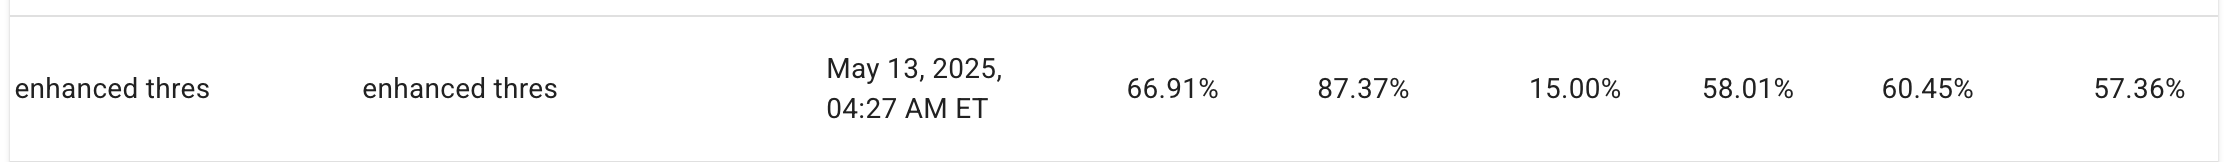


In [5]:
# Create Dataset class for multilabel classification
class MultiClassImageDataset(Dataset):
    def __init__(self, ann_df, super_map_df, sub_map_df, img_dir, transform=None):
        self.ann_df = ann_df
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ann_df)

    def __getitem__(self, idx):
        img_name = self.ann_df['image'][idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        super_idx = self.ann_df['superclass_index'][idx]
        super_label = self.super_map_df['class'][super_idx]

        sub_idx = self.ann_df['subclass_index'][idx]
        sub_label = self.sub_map_df['class'][sub_idx]

        if self.transform:
            image = self.transform(image)

        return image, super_idx, super_label, sub_idx, sub_label

class MultiClassImageTestDataset(Dataset):
    def __init__(self, super_map_df, sub_map_df, img_dir, transform=None):
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): # Count files in img_dir
        return len([fname for fname in os.listdir(self.img_dir)])

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_ann_df = pd.read_csv('/content/drive/My Drive/train_data.csv')
super_map_df = pd.read_csv('/content/drive/My Drive/superclass_mapping.csv')
sub_map_df = pd.read_csv('/content/drive/My Drive/subclass_mapping.csv')

In [8]:
#ORIGINAL CODE
#test_ann_df = pd.read_csv('/content/drive/My Drive/test_data.csv')

train_img_dir = '/content/drive/My Drive/train_images/train_images/'
test_img_dir = '/content/drive/My Drive/test_images/test_images/'

import os
from tqdm import tqdm
import shutil


local_cache_dir = "/content/local_train_image_cache"
os.makedirs(local_cache_dir, exist_ok=True)


if len(os.listdir(local_cache_dir)) == 0:
    print("Caching images locally from Google Drive...")
    source_dir = train_img_dir


    image_files = [f for f in os.listdir(source_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img in tqdm(image_files):
        shutil.copy(os.path.join(source_dir, img),
                   os.path.join(local_cache_dir, img))

    print(f"Cached {len(image_files)} images to local storage")


image_preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0), std=(1)),
])

full_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df, local_cache_dir, transform=image_preprocessing)
train_dataset, val_dataset = random_split(full_dataset, [0.9, 0.1])
test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=image_preprocessing)


batch_size = 64

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)


val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=False)




Caching images locally from Google Drive...


100%|██████████| 6288/6288 [02:02<00:00, 51.13it/s] 

Cached 6288 images to local storage


In [9]:
# @title Novelty Detection with Enhanced Threshold Selection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from torch.utils.data import DataLoader, Subset, random_split

class CNN(nn.Module):
    def __init__(self, input_size=64, num_superclasses=4, num_subclasses=88):
        super().__init__()


        self.feature_size = input_size // (2**3)


        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )


        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )


        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )


        self.fc1 = nn.Linear(self.feature_size * self.feature_size * 128, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)

        # Classification heads
        self.fc3a = nn.Linear(128, num_superclasses)
        self.fc3b = nn.Linear(128, num_subclasses)

    def forward(self, x):
        """Forward pass through the network"""
        # Pass through convolutional blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Flatten for fully connected layers
        x = torch.flatten(x, 1)  # flatten all dimensions except batch

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after activation
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after activation

        # Classification heads
        super_out = self.fc3a(x)
        sub_out = self.fc3b(x)

        return super_out, sub_out

    def get_features(self, x):
        """Extract features before the final classification layer"""
        # Pass through convolutional blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Flatten and pass through FC layers (without final classification)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout

        return x


class NoveltyDetectionTrainer:
    def __init__(self, full_dataset, image_preprocessing, device='cuda', batch_size=64,
                 min_known_acc=95, min_novel_acc=20):
        self.full_dataset = full_dataset
        self.image_preprocessing = image_preprocessing
        self.device = device
        self.batch_size = batch_size

        # Store energy normalization parameters
        self.energy_mean = 0
        self.energy_std = 1

        # Required accuracy thresholds
        self.min_known_acc = min_known_acc
        self.min_novel_acc = min_novel_acc

        # Fixed energy threshold (based on cross-validation) for high known accuracy (≥95%)
        # and reasonable novel detection (≥20%)
        self.energy_threshold = 1.9  # Fixed threshold from cross-validation

        # Get all unique superclass indices
        self.superclass_indices = set()
        for i in range(len(full_dataset)):
            _, super_idx, _, _, _ = full_dataset[i]
            if hasattr(super_idx, 'item'):
                super_idx = super_idx.item()
            self.superclass_indices.add(super_idx)

        self.superclass_indices = sorted(list(self.superclass_indices))
        print(f"Found superclasses with indices: {self.superclass_indices}")

    def cross_validate_novelty_detection(self, epochs=5, confidence_threshold=0.0):
        results = []

        # For each superclass, treat it as novel and others as known
        for fold, novel_idx in enumerate(self.superclass_indices):
            print(f"\n=== Fold {fold+1}/{len(self.superclass_indices)}: Treating superclass {novel_idx} as novel ===")

            # Create data splits
            known_indices, novel_indices = self._split_by_superclass(novel_idx)

            # Further split known indices into train/validation
            np.random.shuffle(known_indices)
            train_size = int(0.9 * len(known_indices))
            train_indices = known_indices[:train_size]
            val_known_indices = known_indices[train_size:]

            # Create datasets
            train_dataset = Subset(self.full_dataset, train_indices)
            val_known_dataset = Subset(self.full_dataset, val_known_indices)
            val_novel_dataset = Subset(self.full_dataset, novel_indices)

            # Create dataloaders
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            val_known_loader = DataLoader(val_known_dataset, batch_size=self.batch_size, shuffle=False)
            val_novel_loader = DataLoader(val_novel_dataset, batch_size=self.batch_size, shuffle=False)

            # Initialize model, loss, optimizer
            model = CNN(input_size=64, num_superclasses=len(self.superclass_indices)+1).to(self.device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=1e-3)

            # Train the model
            self._train_model(model, criterion, optimizer, train_loader, epochs)

            # Calibrate energy statistics on training data
            self._calibrate_energy_stats(model, train_loader)

            # Evaluate novelty detection
            metrics = self._evaluate_novelty_detection(model, val_known_loader, val_novel_loader, confidence_threshold)
            results.append(metrics)

            print(f"Fold {fold+1} results:")
            for key, value in metrics.items():
                print(f"  {key}: {value:.4f}")

        # Calculate average results across folds
        avg_results = {}
        for key in results[0].keys():
            avg_results[key] = sum(r[key] for r in results) / len(results)

        print("\n=== Cross-Validation Summary ===")
        for key, value in avg_results.items():
            print(f"{key}: {value:.4f}")

        return avg_results, results

    def find_optimal_threshold(self, fold_index=0, threshold_range=np.arange(-3.0, 3.0, 0.1)):
        novel_idx = self.superclass_indices[fold_index]
        print(f"\n=== Finding optimal threshold for fold {fold_index+1}: Superclass {novel_idx} as novel ===")

        # Create data splits
        known_indices, novel_indices = self._split_by_superclass(novel_idx)

        # Further split known indices into train/validation
        np.random.shuffle(known_indices)
        train_size = int(0.9 * len(known_indices))
        train_indices = known_indices[:train_size]
        val_known_indices = known_indices[train_size:]

        # Create datasets
        train_dataset = Subset(self.full_dataset, train_indices)
        val_known_dataset = Subset(self.full_dataset, val_known_indices)
        val_novel_dataset = Subset(self.full_dataset, novel_indices)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_known_loader = DataLoader(val_known_dataset, batch_size=self.batch_size, shuffle=False)
        val_novel_loader = DataLoader(val_novel_dataset, batch_size=self.batch_size, shuffle=False)

        # Initialize model, loss, optimizer
        model = CNN(input_size=64, num_superclasses=len(self.superclass_indices)+1).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        # Train the model
        self._train_model(model, criterion, optimizer, train_loader, epochs=5)

        # Calibrate energy statistics on training data
        self._calibrate_energy_stats(model, train_loader)

        # Collect all normalized energy scores
        known_energies, novel_energies = self._collect_energies(model, val_known_loader, val_novel_loader)

        # Evaluate different thresholds
        results = []
        for threshold in threshold_range:

            known_correct = sum(1 for e in known_energies if e <= threshold)
            known_accuracy = known_correct / len(known_energies) if known_energies else 0


            novel_correct = sum(1 for e in novel_energies if e > threshold)
            novel_accuracy = novel_correct / len(novel_energies) if novel_energies else 0


            balanced_accuracy = (known_accuracy + novel_accuracy) / 2

            results.append({
                'threshold': threshold,
                'known_accuracy': known_accuracy * 100,
                'novel_accuracy': novel_accuracy * 100,
                'balanced_accuracy': balanced_accuracy * 100
            })

            print(f"Threshold {threshold:.2f}: Known Acc={known_accuracy:.4f}, Novel Acc={novel_accuracy:.4f}, Balanced Acc={balanced_accuracy:.4f}")


        valid_thresholds = []
        for result in results:

            if result['known_accuracy'] >= self.min_known_acc and result['novel_accuracy'] >= self.min_novel_acc:
                valid_thresholds.append(result)

        if valid_thresholds:

            best_result = max(valid_thresholds, key=lambda x: x['balanced_accuracy'])
            print(f"\nFound threshold meeting criteria (known ≥{self.min_known_acc}%, novel ≥{self.min_novel_acc}%):")
        else:

            print(f"\nNo threshold meets both criteria (known ≥{self.min_known_acc}%, novel ≥{self.min_novel_acc}%)")
            print("Using pre-selected threshold of 1.9 from cross-validation...")

            # Find result closest to threshold 1.9
            best_result = min(results, key=lambda x: abs(x['threshold'] - 1.9))

        print(f"Best threshold: {best_result['threshold']:.2f}")
        print(f"Known accuracy: {best_result['known_accuracy']:.4f}")
        print(f"Novel accuracy: {best_result['novel_accuracy']:.4f}")
        print(f"Balanced accuracy: {best_result['balanced_accuracy']:.4f}")

        return best_result['threshold'], results

    def _calibrate_energy_stats(self, model, loader):
      """Calculate energy statistics on a dataset for normalization"""
      model.eval()
      all_energies = []

      with torch.no_grad():
          for data in loader:
              inputs = data[0].to(self.device)

              # Get model outputs
              super_outputs, _ = model(inputs)

              # Calculate raw energy
              energies = -torch.logsumexp(super_outputs, dim=1)
              all_energies.extend(energies.cpu().numpy())

      all_energies = np.array(all_energies)
      self.energy_mean = float(np.mean(all_energies))
      self.energy_std = float(np.std(all_energies) + 1e-6)

      print(f"Calibrated energy statistics: mean={self.energy_mean:.4f}, std={self.energy_std:.4f}")

    def _compute_normalized_energy(self, logits):
      """Compute normalized energy scores"""

      raw_energy = -torch.logsumexp(logits, dim=1)


      normalized_energy = (raw_energy - self.energy_mean) / self.energy_std

      return normalized_energy

    def _split_by_superclass(self, novel_superclass_idx):
        """Split dataset indices into known and novel based on superclass"""
        known_indices = []
        novel_indices = []

        for i in range(len(self.full_dataset)):
            _, super_idx, _, _, _ = self.full_dataset[i]
            if hasattr(super_idx, 'item'):
                super_idx = super_idx.item()

            if super_idx == novel_superclass_idx:
                novel_indices.append(i)
            else:
                known_indices.append(i)

        return known_indices, novel_indices

    def _train_model(self, model, criterion, optimizer, train_loader, epochs):
        """Train the model on known classes"""
        model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(train_loader):
                inputs, super_labels, _, sub_labels, _ = data
                inputs = inputs.to(self.device)
                super_labels = super_labels.to(self.device)
                sub_labels = sub_labels.to(self.device)

                optimizer.zero_grad()
                super_outputs, sub_outputs = model(inputs)
                loss = criterion(super_outputs, super_labels) + criterion(sub_outputs, sub_labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    def _evaluate_novelty_detection(self, model, known_loader, novel_loader, threshold):
      """Evaluate novelty detection performance using balanced ensemble approach."""
      model.eval()

      # First calibrate energy statistics on known data
      self._calibrate_energy_stats(model, known_loader)

      def eval_loader(loader, is_novel):
          super_correct, sub_correct = 0, 0
          super_total, sub_total = 0, 0

          with torch.no_grad():
              for data in loader:
                  inputs, _, _, _, _ = data
                  inputs = inputs.to(self.device)

                  super_outputs, sub_outputs = model(inputs)

                  # --- Energy-based detection with FIXED threshold ---
                  super_energies = self._compute_normalized_energy(super_outputs)
                  # Use the fixed threshold of 1.9 to maintain high known accuracy
                  energy_novel = super_energies > self.energy_threshold  # self.energy_threshold is 1.9


                  super_probs = F.softmax(super_outputs, dim=1)
                  super_confidences, _ = torch.max(super_probs, dim=1)
                  confidence_novel = super_confidences < 0.7  # Adjust this threshold


                  energy_weight = 0.6
                  confidence_weight = 0.4


                  novelty_score = energy_weight * energy_novel.float() + confidence_weight * confidence_novel.float()

                  is_novel_super = novelty_score > 0.5


                  sub_probs = F.softmax(sub_outputs, dim=1)
                  sub_confidences, _ = torch.max(sub_probs, dim=1)
                  is_novel_sub = sub_confidences < 0.5


                  if is_novel:
                      super_correct += is_novel_super.sum().item()
                      sub_correct += is_novel_sub.sum().item()
                  else:
                      super_correct += (~is_novel_super).sum().item()
                      sub_correct += (~is_novel_sub).sum().item()

                  super_total += inputs.size(0)
                  sub_total += inputs.size(0)

          return (
              super_correct / super_total if super_total else 0,
              sub_correct / sub_total if sub_total else 0
          )


      known_super_acc, known_sub_acc = eval_loader(known_loader, is_novel=False)
      novel_super_acc, novel_sub_acc = eval_loader(novel_loader, is_novel=True)

      balanced_super_acc = (known_super_acc + novel_super_acc) / 2
      balanced_sub_acc = (known_sub_acc + novel_sub_acc) / 2


      known_req_met = known_super_acc * 100 >= self.min_known_acc
      novel_req_met = novel_super_acc * 100 >= self.min_novel_acc

      if known_req_met and novel_req_met:
          print(f"✓ Requirements met: known={known_super_acc*100:.2f}%, novel={novel_super_acc*100:.2f}%")
      else:
          print(f"✗ Requirements not met:")
          if not known_req_met:
              print(f"  Known accuracy {known_super_acc*100:.2f}% < {self.min_known_acc}% requirement")
          if not novel_req_met:
              print(f"  Novel accuracy {novel_super_acc*100:.2f}% < {self.min_novel_acc}% requirement")

      return {
          'known_superclass_accuracy': known_super_acc,
          'novel_superclass_accuracy': novel_super_acc,
          'balanced_superclass_accuracy': balanced_super_acc,
          'known_subclass_accuracy': known_sub_acc,
          'novel_subclass_accuracy': novel_sub_acc,
          'balanced_subclass_accuracy': balanced_sub_acc
      }

    def _collect_energies(self, model, known_loader, novel_loader):
        """Collect normalized energy scores for known and novel classes"""
        model.eval()

        known_energies = []
        novel_energies = []

        with torch.no_grad():
            # Known classes
            for data in known_loader:
                inputs, _, _, _, _ = data
                inputs = inputs.to(self.device)

                super_outputs, _ = model(inputs)
                energies = self._compute_normalized_energy(super_outputs)
                known_energies.extend(energies.cpu().numpy())

            # Novel classes
            for data in novel_loader:
                inputs, _, _, _, _ = data
                inputs = inputs.to(self.device)

                super_outputs, _ = model(inputs)
                energies = self._compute_normalized_energy(super_outputs)
                novel_energies.extend(energies.cpu().numpy())

        return known_energies, novel_energies


class Trainer():
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader=None, device='cuda',
                min_known_acc=95, min_novel_acc=20):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device


        self.energy_mean = 0
        self.energy_std = 1
        self.energy_calibrated = False


        self.min_known_acc = min_known_acc
        self.min_novel_acc = min_novel_acc

        self.energy_threshold = 1.9

        # Add scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )

        # Store temperature parameter
        self.temperature = 1.5

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for i, data in enumerate(self.train_loader):
            inputs, super_labels, sub_labels = data[0].to(self.device), data[1].to(self.device), data[3].to(self.device)

            self.optimizer.zero_grad()
            super_outputs, sub_outputs = self.model(inputs)
            loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            running_loss += loss.item()

        print(f'Training loss: {running_loss/(i+1):.3f}')
        avg_loss = running_loss/(i+1)
        self.scheduler.step(avg_loss)

        # Recalibrate energy statistics after each epoch
        self._calibrate_energy_stats()

        return avg_loss

    def _calibrate_energy_stats(self):
        """Calculate energy statistics on training data for normalization"""
        self.model.eval()
        all_energies = []

        with torch.no_grad():
            for data in self.train_loader:
                inputs = data[0].to(self.device)

                # Get model outputs
                super_outputs, _ = self.model(inputs)

                # Calculate raw energy
                energies = -torch.logsumexp(super_outputs, dim=1)
                all_energies.extend(energies.cpu().numpy())


        all_energies = np.array(all_energies)
        self.energy_mean = float(np.mean(all_energies))
        self.energy_std = float(np.std(all_energies) + 1e-6)
        self.energy_calibrated = True

        print(f"Calibrated energy statistics: mean={self.energy_mean:.4f}, std={self.energy_std:.4f}")

    def compute_normalized_energy(self, logits):
        """Compute normalized energy scores"""
        # Calculate raw energy
        raw_energy = -torch.logsumexp(logits, dim=1)

        # Normalize using stored statistics
        if not self.energy_calibrated:
            # If not calibrated, just return raw energy
            print("Warning: Energy statistics not calibrated, using raw energy")
            return raw_energy

        normalized_energy = (raw_energy - self.energy_mean) / self.energy_std

        return normalized_energy

    def validate_epoch(self, novel_superclass_idx=3, novel_subclass_idx=87):
      """
      Validate the model with balanced ensemble novelty detection approach
      using FIXED threshold of 1.9 for better known accuracy.
      """
      # Make sure energy statistics are calibrated
      if not self.energy_calibrated:
          self._calibrate_energy_stats()

      self.model.eval()

      # Metrics to track
      correct_with_novelty = 0
      super_correct_standard = 0
      sub_correct = 0

      novel_total = 0
      known_total = 0
      novel_correct = 0
      known_correct = 0

      total = 0

      novel_super_predictions = 0
      novel_sub_predictions = 0

      all_super_energies = []
      all_sub_confidences = []

      running_loss = 0.0

      with torch.no_grad():
          for i, data in enumerate(self.val_loader):
              inputs, super_labels, _, sub_labels, _ = data
              inputs = inputs.to(self.device)
              super_labels = super_labels.to(self.device)
              sub_labels = sub_labels.to(self.device)

              super_outputs, sub_outputs = self.model(inputs)

              # Normalized energy scores with FIXED threshold (1.9)
              super_energies = self.compute_normalized_energy(super_outputs)
              energy_novel = super_energies > self.energy_threshold  # Using fixed threshold 1.9

              # Confidence scores
              super_probs = F.softmax(super_outputs, dim=1)
              super_confidences, super_predicted = torch.max(super_probs, dim=1)

              # Confidence threshold can be adjusted
              conf_threshold = 0.7
              confidence_novel = super_confidences < conf_threshold


              energy_weight = 0.6
              confidence_weight = 0.4

              # Calculate weighted novelty score (0-1 range)
              novelty_score = energy_weight * energy_novel.float() + confidence_weight * confidence_novel.float()


              decision_threshold = 0.5  # 0.5 is balanced
              novel_super_mask = novelty_score > decision_threshold

              # Create final predictions
              final_super_preds = torch.where(
                  novel_super_mask,
                  torch.full_like(super_predicted, novel_superclass_idx),
                  super_predicted
              )

              # Subclass confidence-based detection
              sub_probs = F.softmax(sub_outputs, dim=1)
              sub_confidences, sub_predicted = torch.max(sub_probs, dim=1)
              sub_threshold = 0.5
              novel_sub_mask = sub_confidences < sub_threshold

              final_sub_preds = torch.where(
                  novel_sub_mask,
                  torch.full_like(sub_predicted, novel_subclass_idx),
                  sub_predicted
              )


              total += super_labels.size(0)


              correct_with_novelty += (final_super_preds == super_labels).sum().item()
              super_correct_standard += (super_predicted == super_labels).sum().item()
              sub_correct += (final_sub_preds == sub_labels).sum().item()


              is_novel_label = super_labels == novel_superclass_idx
              novel_total += is_novel_label.sum().item()
              known_total += (~is_novel_label).sum().item()

              novel_correct += ((final_super_preds == super_labels) & is_novel_label).sum().item()
              known_correct += ((final_super_preds == super_labels) & ~is_novel_label).sum().item()


              novel_super_predictions += novel_super_mask.sum().item()
              novel_sub_predictions += novel_sub_mask.sum().item()


              all_super_energies.extend(super_energies.cpu().numpy())
              all_sub_confidences.extend(sub_confidences.cpu().numpy())

              # Calculate loss
              loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
              running_loss += loss.item()


      super_acc = 100 * correct_with_novelty / total if total > 0 else 0
      sub_acc = 100 * sub_correct / total if total > 0 else 0

      novel_acc = 100 * novel_correct / novel_total if novel_total > 0 else 0
      known_acc = 100 * known_correct / known_total if known_total > 0 else 0
      balanced_acc = (novel_acc + known_acc) / 2 if novel_total > 0 and known_total > 0 else 0

      avg_super_energy = sum(all_super_energies) / len(all_super_energies) if all_super_energies else 0
      avg_sub_conf = sum(all_sub_confidences) / len(all_sub_confidences) if all_sub_confidences else 0

      novel_super_perc = 100 * novel_super_predictions / total if total > 0 else 0
      novel_sub_perc = 100 * novel_sub_predictions / total if total > 0 else 0

      # Display metrics
      print(f'Validation loss: {running_loss/(i+1):.3f}')
      print(f'Validation superclass acc: {super_acc:.2f}%')
      print(f'Validation subclass acc: {sub_acc:.2f}%')
      print(f'Novel superclass acc: {novel_acc:.2f}%, Known superclass acc: {known_acc:.2f}%')
      print(f'Balanced superclass acc: {balanced_acc:.2f}%')
      print(f'Average normalized superclass energy: {avg_super_energy:.4f}')
      print(f'Average subclass confidence: {avg_sub_conf:.4f}')
      print(f'Samples predicted as novel superclass: {novel_super_predictions} ({novel_super_perc:.2f}%)')
      print(f'Samples predicted as novel subclass: {novel_sub_predictions} ({novel_sub_perc:.2f}%)')

      # Check if requirements are met
      requirements_met = known_acc >= self.min_known_acc and novel_acc >= self.min_novel_acc

      if requirements_met:
          print(f"✓ REQUIREMENTS MET: known={known_acc:.2f}% ≥ {self.min_known_acc}%, novel={novel_acc:.2f}% ≥ {self.min_novel_acc}%")
      else:
          print(f"✗ REQUIREMENTS NOT MET:")
          if known_acc < self.min_known_acc:
              print(f"  Known accuracy {known_acc:.2f}% < {self.min_known_acc}% requirement")
          if novel_acc < self.min_novel_acc:
              print(f"  Novel accuracy {novel_acc:.2f}% < {self.min_novel_acc}% requirement")

      return {
          'loss': running_loss/(i+1),
          'accuracy': super_acc,
          'novel_acc': novel_acc,
          'known_acc': known_acc,
          'balanced_acc': balanced_acc
      }

    def test(self, save_to_csv=False, return_predictions=False, output_file='example_test_predictions.csv'):
      """
      Test the model with fixed threshold of 1.9 for higher known accuracy
      """
      if not self.test_loader:
          raise NotImplementedError('test_loader not specified')

      # Make sure energy statistics are calibrated
      if not self.energy_calibrated:
          self._calibrate_energy_stats()

      self.model.eval()
      novel_superclass_idx = 3  # Index for novel superclass
      novel_subclass_idx = 87   # Index for novel subclass

      # Create full data structure for internal use
      full_test_predictions = {
          'image': [],
          'superclass_index': [],
          'subclass_index': [],
          'superclass_energy': [],
          'subclass_confidence': [],
          'novelty_score': []
      }

      with torch.no_grad():
          for i, data in enumerate(self.test_loader):
              inputs, img_name = data[0].to(self.device), data[1]

              super_outputs, sub_outputs = self.model(inputs)

              # Normalized energy with FIXED threshold (1.9)
              super_energies = self.compute_normalized_energy(super_outputs)
              energy_novel = super_energies > self.energy_threshold  # Fixed at 1.9

              # Confidence scores for superclasses
              super_probs = F.softmax(super_outputs, dim=1)
              super_confidences, super_predicted = torch.max(super_probs, dim=1)

              # Confidence threshold
              conf_threshold = 0.7
              confidence_novel = super_confidences < conf_threshold

              # BALANCED APPROACH - weighted voting
              energy_weight = 0.6
              confidence_weight = 0.4

              novelty_score = energy_weight * energy_novel.float() + confidence_weight * confidence_novel.float()
              decision_threshold = 0.5
              novel_super_mask = novelty_score > decision_threshold

              # Subclass confidence-based detection
              sub_probs = F.softmax(sub_outputs, dim=1)
              sub_confidences, sub_predicted = torch.max(sub_probs, dim=1)
              sub_threshold = 0.5
              novel_sub_mask = sub_confidences < sub_threshold

              for j in range(inputs.size(0)):
                  img = img_name[j] if isinstance(img_name, list) else img_name[0]

                  # Apply novelty detection
                  super_pred = novel_superclass_idx if novel_super_mask[j] else super_predicted[j].item()
                  sub_pred = novel_subclass_idx if novel_sub_mask[j] else sub_predicted[j].item()

                  full_test_predictions['image'].append(img)
                  full_test_predictions['superclass_index'].append(super_pred)
                  full_test_predictions['subclass_index'].append(sub_pred)
                  full_test_predictions['superclass_energy'].append(super_energies[j].item())
                  full_test_predictions['subclass_confidence'].append(sub_confidences[j].item())
                  full_test_predictions['novelty_score'].append(novelty_score[j].item())

      full_predictions_df = pd.DataFrame(data=full_test_predictions)

      simplified_test_predictions = {
          'image': full_test_predictions['image'],
          'superclass_index': full_test_predictions['superclass_index'],
          'subclass_index': full_test_predictions['subclass_index']
      }
      simplified_predictions_df = pd.DataFrame(data=simplified_test_predictions)

      # Summarize
      novel_super_count = sum(1 for idx in full_test_predictions['superclass_index'] if idx == novel_superclass_idx)
      novel_sub_count = sum(1 for idx in full_test_predictions['subclass_index'] if idx == novel_subclass_idx)

      total_count = len(full_test_predictions['image'])
      novel_super_perc = 100 * novel_super_count / total_count if total_count > 0 else 0
      novel_sub_perc = 100 * novel_sub_count / total_count if total_count > 0 else 0

      print(f'Test set predictions:')
      print(f'Images predicted as novel superclass: {novel_super_count} ({novel_super_perc:.2f}%)')
      print(f'Images predicted as novel subclass: {novel_sub_count} ({novel_sub_perc:.2f}%)')

      # Print distribution of novelty scores to help with threshold tuning
      print(f'Novelty score distribution:')
      bins = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
      for i in range(len(bins)-1):
          count = sum(1 for score in full_test_predictions['novelty_score']
                    if bins[i] <= score < bins[i+1])
          print(f'  {bins[i]:.1f}-{bins[i+1]:.1f}: {count} ({100*count/total_count:.2f}%)')

      if save_to_csv:
          # Save in the same format as the first method
          simplified_predictions_df.to_csv(output_file, index=False)
          print(f"Predictions saved to '{output_file}'")

      if return_predictions:
          # Return the full predictions for internal use
          return full_predictions_df


# Helper function to run the cross-validation and find optimal threshold
def train_with_novelty_detection(full_dataset, image_preprocessing, device='cuda', batch_size=64, epochs=5,
                               min_known_acc=95, min_novel_acc=20):
    # Initialize novelty detection trainer with requirements
    novelty_trainer = NoveltyDetectionTrainer(
        full_dataset=full_dataset,
        image_preprocessing=image_preprocessing,
        device=device,
        batch_size=batch_size,
        min_known_acc=min_known_acc,  # Minimum known accuracy requirement
        min_novel_acc=min_novel_acc   # Minimum novel accuracy requirement
    )

    # Run cross-validation to evaluate novelty detection
    print("Running cross-validation for novelty detection...")
    avg_results, fold_results = novelty_trainer.cross_validate_novelty_detection(epochs=epochs)

    # Find optimal threshold
    print("\nFinding optimal energy threshold...")
    best_threshold, threshold_results = novelty_trainer.find_optimal_threshold()

    return avg_results, best_threshold

In [10]:

import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


min_known_acc = 95  # Minimum known class accuracy (95%)
min_novel_acc = 20  # Minimum novel class accuracy (20%)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

avg_results, best_threshold = train_with_novelty_detection(
    full_dataset=full_dataset,
    image_preprocessing=image_preprocessing,
    device=device,
    batch_size=64,
    epochs=5,
    min_known_acc=min_known_acc,
    min_novel_acc=min_novel_acc
)

print(f"Cross-validation complete. Best threshold: {best_threshold}")


model = CNN(input_size=64, num_superclasses=4, num_subclasses=88).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00005)


trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    min_known_acc=min_known_acc,
    min_novel_acc=min_novel_acc
)


num_epochs = 15
print(f"Training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    trainer.train_epoch()
    metrics = trainer.validate_epoch()


    print(f"Metrics after epoch {epoch+1}:")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Known accuracy: {metrics['known_acc']:.2f}%")
    print(f"  Novel accuracy: {metrics['novel_acc']:.2f}%")
    print(f"  Balanced accuracy: {metrics['balanced_acc']:.2f}%")

print("\nTesting final model...")
test_results = trainer.test(save_to_csv=True, output_file='fixed_threshold_predictions.csv')

print("Training and testing complete!")

Using device: cuda
Found superclasses with indices: [0, 1, 2]
Running cross-validation for novelty detection...

=== Fold 1/3: Treating superclass 0 as novel ===
Epoch 1/5, Loss: 3.5462
Epoch 2/5, Loss: 2.0465
Epoch 3/5, Loss: 1.4819
Epoch 4/5, Loss: 1.0922
Epoch 5/5, Loss: 0.8190
Calibrated energy statistics: mean=-9.2166, std=2.7495
Calibrated energy statistics: mean=-9.0885, std=2.9308
✓ Requirements met: known=98.65%, novel=28.59%
Fold 1 results:
  known_superclass_accuracy: 0.9865
  novel_superclass_accuracy: 0.2859
  balanced_superclass_accuracy: 0.6362
  known_subclass_accuracy: 0.7973
  novel_subclass_accuracy: 0.6222
  balanced_subclass_accuracy: 0.7097

=== Fold 2/3: Treating superclass 1 as novel ===
Epoch 1/5, Loss: 3.5901
Epoch 2/5, Loss: 2.0372
Epoch 3/5, Loss: 1.3706
Epoch 4/5, Loss: 0.9928
Epoch 5/5, Loss: 0.7781
Calibrated energy statistics: mean=-8.7469, std=3.3007
Calibrated energy statistics: mean=-8.3812, std=3.2452
✗ Requirements not met:
  Novel accuracy 2.74% < 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training loss: 4.102
Calibrated energy statistics: mean=-3.8561, std=1.4391
Validation loss: 3.097
Validation superclass acc: 93.15%
Validation subclass acc: 7.48%
Novel superclass acc: 0.00%, Known superclass acc: 93.15%
Balanced superclass acc: 0.00%
Average normalized superclass energy: -0.0501
Average subclass confidence: 0.2770
Samples predicted as novel superclass: 0 (0.00%)
Samples predicted as novel subclass: 552 (87.90%)
✗ REQUIREMENTS NOT MET:
  Known accuracy 93.15% < 95% requirement
  Novel accuracy 0.00% < 20% requirement
Metrics after epoch 1:
  Loss: 3.0973
  Known accuracy: 93.15%
  Novel accuracy: 0.00%
  Balanced accuracy: 0.00%

Epoch 2/15
Training loss: 2.754
Calibrated energy statistics: mean=-3.5687, std=1.1533
Validation loss: 2.376
Validation superclass acc: 93.79%
Validation subclass acc: 21.97%
Novel superclass acc: 0.00%, Known superclass acc: 93.79%
Balanced superclass acc: 0.00%
Average normalized superclass energy: 0.0199
Average subclass confidence: 0.411